In [429]:
from mesa.space import MultiGrid
from mesa import Agent, Model
from mesa.time import RandomActivation
from random import random, randint
from numpy.random import choice
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

def get_x(model):
    agent_positions = [a.pos for a in model3.schedule.agents]
    return(agent_positions)
    

    
class PersonAgent3(Agent):
    """An agent with fixed initial wealth."""
    def __init__(self, unique_id, dep, obs, dpsh, obsh, model):
        super().__init__(unique_id, model)
        self.depressed = dep
        #for depress 0-50 = not depress, 51-100 = yes
        self.obese = obs
        #for obese 0-50 = not obese, 51-100 = yes
        self.seekhelpDP = dpsh
        self.seekhelpOB = obsh
    
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_to_empty(self)
    
    def keeprange(self):
        if self.obese < 0:
            self.obese = 0
        elif self.obese > 100:
            self.obese = 100
        else:
            self.obese = self.obese
        
        if self.depressed < 0:
            self.depressed = 0
        elif self.depressed > 100:
            self.depressed = 100
        else:
            self.depressed = self.depressed
            
    #checking if one random person near the agent has depression and basing increase/decrease
    #based on that person
    def give_depression(self):
        neighbors = self.model.grid.get_neighbors(
            self.pos,
            moore=True,
            include_center=False)
        #neighbors = self.model.grid.get_cell_list_contents([self.pos])
        if len(neighbors) >= 1:
            other = self.random.choice(neighbors)
            if other.depressed <= 50: 
                self.depressed -= 2
                other.depressed += 1
            else:
                other.depressed += 2
                self.depressed += 2
            other.keeprange()
        #Depressed increasing Obese
        if self.depressed > 50:
            give = choice([0,1], 1, p=[0.57,0.43])
            self.obese = int(self.obese + give)
        self.keeprange()
        
            
            
    def give_obese(self):
        neighbors = self.model.grid.get_neighbors(
            self.pos,
            moore=True,
            include_center=False)
        if len(neighbors) >= 1:
            other = self.random.choice(neighbors)
            if other.obese <= 50: 
                self.obese -= 2
                other.obese += 1
            else:
                other.obese += 2
                self.obese += 2
            other.keeprange()
        #Obese increasing Depression
        if self.obese > 50:
            give = choice([0,1], 1, p=[0.80,0.20])
            self.depressed = int(self.depressed + give)
        self.keeprange()
        
            
            
    def step(self):
        # The agent's step will go here.
        self.move()
        self.keeprange()
        ### Seeking Help and Giving
        if self.depressed > 50:
            if self.seekhelpDP == 1:
                self.depressed -= 2
                self.seekhelpDP = choice([0,1], 1, p=[0.79,0.21])
            self.give_depression()
        if self.obese > 50:
            if self.seekhelpOB == 1:
                self.obese -= 2
                self.seekhelpOB = choice([0,1], 1, p=[0.517,0.483])
            self.give_obese()
            

class HealthModel3(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.running = True
        self.num_agents = N
        self.grid = MultiGrid(width, height, False)
        # Create agents
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            dep = choice([0,100], 1, p=[0.924,0.076])
            dep = float(dep)
            obs = choice([0,100],1,p=[0.602, 0.398])
            obs = float(obs)
            dpsh = choice([0,1], 1, p=[0.67,0.33])
            obsh = choice([0,1], 1, p=[0.333, 0.667])
            a = PersonAgent3(i, dep, obs, dpsh, obsh, self)
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
        self.datacollector = DataCollector(
            agent_reporters={"Depressed": "depressed", "Obese" : "obese", "Position":"pos"})
            

    def step(self):
        '''Advance the model by one step.'''
        self.datacollector.collect(self)
        self.schedule.step()
        

model3 = HealthModel3(100, 15, 15)
for i in range(100):
    if i % 100 ==0: print(i)
    model3.step()

import pandas as pd
agent_health3 = pd.DataFrame([{'id':a.unique_id, 'dep':a.depressed, 'obs':a.obese, 'pos':a.pos} for a in model3.schedule.agents])

0


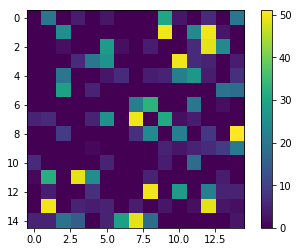

In [430]:
import numpy as np

agent_counts = np.zeros((model3.grid.width, model3.grid.height))
for cell in model3.grid.coord_iter():
    #print(cell)
    cell_content, x, y = cell
    agent_count = len(cell_content)
    if len(cell_content) > 0:
        ob = cell_content.pop()
        dep = ob.depressed
    else:
        dep = 0
    #print(agent_count)
    agent_counts[x][y] = dep
    #print(agent_counts)
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

In [431]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(1, 1, 1)

gini = model3.datacollector.get_agent_vars_dataframe()

def animate_agent(i):
    one_step = gini.xs(i, level = "Step")
    one_step.reset_index(inplace=True)
    x = one_step["AgentID"]
    y1 = one_step['Depressed']
    y2 = one_step['Obese']
    ax1.clear()
    ax1.set_ylim([-10,110])
    ax1.set_xlabel('Agent')
    ax1.set_ylabel('Health')
    ax1.plot(x,y1,'o',label='Depressed')
    ax1.plot(x,y2,'o',label='Obese')
    ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
               ncol=2, mode="expand", borderaxespad=0.)


anim = animation.FuncAnimation(fig, animate_agent, frames=range(0, 100), interval=200, repeat=True)
plt.close()

In [432]:
from IPython.display import HTML
HTML(anim.to_jshtml())